# Chapter 5.3 - Using a pre-trained convnet

In [1]:
# Importing VGG16
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
network = VGG16(weights = 'imagenet', 
                include_top = False,
                input_shape = (150, 150, 3))

In [3]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Preparing the data

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = 'E:/1_GitHub/arcyfelix/Courses/In Progress-Deep Learning With Python by François Chollet/data/Chapter 5.2 - Using convets with small datasets'

In [6]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [7]:
datagen = ImageDataGenerator(rescale = 1. / 255)
batch_size = 20

In [8]:
def extract_features(directory, sample_count):
    # Initializing empty matrixes of a given shape
    features = np.zeros(shape = (sample_count, 4, 4, 512))
    labels = np.zeros(shape = (sample_count))
    
    # Generator
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150, 150),
        batch_size = batch_size,
        class_mode = 'binary')
    # Initializing index
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = network.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [9]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
train_features.shape

(2000, 4, 4, 512)

In [11]:
train_labels.shape

(2000,)

In [12]:
# Flattening the features in order to feed them to a densely-connected classifier
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

## Building a densely-connected classifier

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

In [14]:
model = Sequential()
model.add(Dense(units = 256, 
                activation = 'relu', 
                input_dim = 4 * 4 * 512))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 1, 
                activation = 'sigmoid'))

model.compile(optimizer = RMSprop(lr = 2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

## Training

In [15]:
history = model.fit(train_features, 
                    train_labels,
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 1s - loss: 0.5825 - acc: 0.6875 - val_loss: 0.4301 - val_acc: 0.8450
Epoch 2/30
2000/2000 [==============================] - 1s - loss: 0.4297 - acc: 0.8055 - val_loss: 0.3562 - val_acc: 0.8600
Epoch 3/30
2000/2000 [==============================] - 1s - loss: 0.3550 - acc: 0.8440 - val_loss: 0.3200 - val_acc: 0.8770
Epoch 4/30
2000/2000 [==============================] - 1s - loss: 0.3128 - acc: 0.8730 - val_loss: 0.2966 - val_acc: 0.8850
Epoch 5/30
2000/2000 [==============================] - 1s - loss: 0.2819 - acc: 0.8915 - val_loss: 0.2915 - val_acc: 0.8780
Epoch 6/30
2000/2000 [==============================] - 1s - loss: 0.2630 - acc: 0.8990 - val_loss: 0.2784 - val_acc: 0.8830
Epoch 7/30
2000/2000 [==============================] - 1s - loss: 0.2515 - acc: 0.8980 - val_loss: 0.2629 - val_acc: 0.8900
Epoch 8/30
2000/2000 [==============================] - 1s - loss: 0.2299 - a

## Training visualization

In [16]:
import matplotlib.pyplot as plt

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [18]:
epochs = range(len(acc))

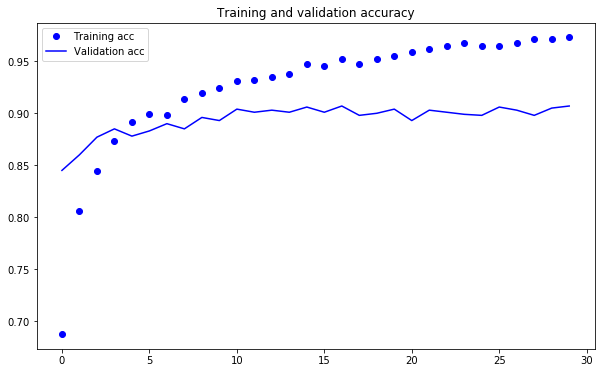

In [19]:
plt.figure(figsize = (10, 6))

plt.plot(epochs, 
         acc, 
         'bo', 
         label = 'Training acc')

plt.plot(epochs, 
         val_acc, 
         'b', 
         label = 'Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.show()

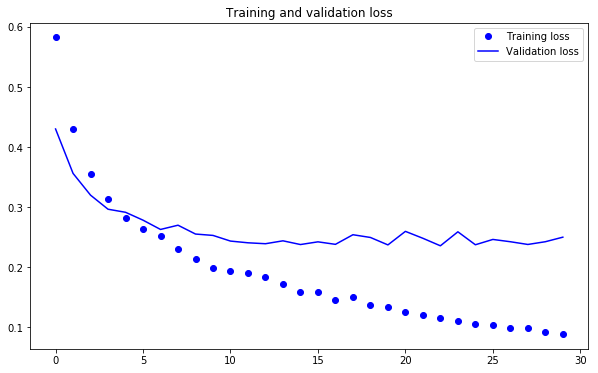

In [20]:
plt.figure(figsize = (10, 6))

plt.plot(epochs, 
         loss, 
         'bo', 
         label = 'Training loss')

plt.plot(epochs, 
         val_loss, 
         'b', 
         label = 'Validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

## Running end-to-end model

In [21]:
from keras.layers import Flatten

In [22]:
end_to_end_model = Sequential()
end_to_end_model.add(network)
end_to_end_model.add(Flatten())
end_to_end_model.add(Dense(units = 256, 
                           activation = 'relu'))
end_to_end_model.add(Dense(units = 1, 
                           activation = 'sigmoid'))

In [23]:
end_to_end_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [24]:
print('Trainable weights before freezing the VGG base:', len(end_to_end_model.trainable_weights))

Trainable weights before freezing the VGG base: 30


In [25]:
# Freezing VGG part of the network
network.trainable = False

In [26]:
print('Trainable weights after freezing the VGG base:', len(end_to_end_model.trainable_weights))

Trainable weights after freezing the VGG base: 4


In [27]:
# Compiling the network
end_to_end_model.compile(loss = 'binary_crossentropy',
                         optimizer = RMSprop(lr = 2e-5),
                         metrics = ['acc'])

## Loading augmented data

In [28]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

# The validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255)

In [29]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size = (150, 150),
        batch_size = 20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode = 'binary')

Found 2000 images belonging to 2 classes.


In [30]:
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                        target_size = (150, 150),
                                                        batch_size = 20,
                                                        class_mode = 'binary')

Found 1000 images belonging to 2 classes.


## Training

In [31]:
history = end_to_end_model.fit_generator(train_generator,
                              steps_per_epoch = 100,
                              epochs = 30,
                              validation_data = validation_generator,
                              validation_steps = 50, 
                              verbose = 2)

Epoch 1/30
44s - loss: 0.5217 - acc: 0.7300 - val_loss: 0.2741 - val_acc: 0.8930
Epoch 2/30
41s - loss: 0.2965 - acc: 0.8675 - val_loss: 0.1732 - val_acc: 0.9270
Epoch 3/30
41s - loss: 0.2317 - acc: 0.8975 - val_loss: 0.2138 - val_acc: 0.9000
Epoch 4/30
41s - loss: 0.1805 - acc: 0.9290 - val_loss: 0.1841 - val_acc: 0.9450
Epoch 5/30
41s - loss: 0.1684 - acc: 0.9325 - val_loss: 0.1057 - val_acc: 0.9530
Epoch 6/30
41s - loss: 0.1327 - acc: 0.9445 - val_loss: 0.1000 - val_acc: 0.9680
Epoch 7/30
41s - loss: 0.1293 - acc: 0.9510 - val_loss: 0.0863 - val_acc: 0.9680
Epoch 8/30
41s - loss: 0.1072 - acc: 0.9615 - val_loss: 0.4918 - val_acc: 0.8740
Epoch 9/30
41s - loss: 0.1066 - acc: 0.9590 - val_loss: 0.1362 - val_acc: 0.9460
Epoch 10/30
41s - loss: 0.0946 - acc: 0.9630 - val_loss: 0.1202 - val_acc: 0.9640
Epoch 11/30
41s - loss: 0.0935 - acc: 0.9650 - val_loss: 0.0830 - val_acc: 0.9680
Epoch 12/30
41s - loss: 0.0946 - acc: 0.9645 - val_loss: 0.0808 - val_acc: 0.9680
Epoch 13/30
41s - loss: 0

In [32]:
model.save('.\saved_checkpoints\Chapter 5.3 - Using a pre-trained convnet\cats_and_dogs_small_3.h5')

## Visualization

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [34]:
epochs = range(len(acc))

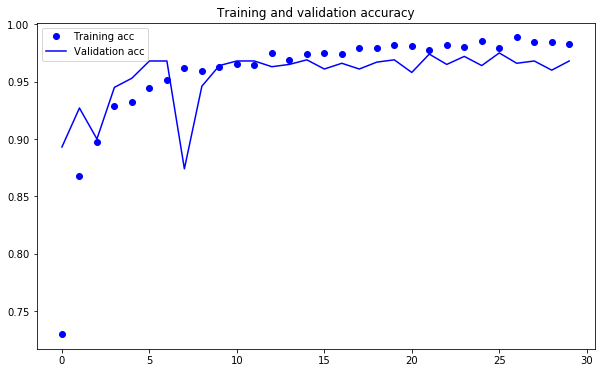

In [35]:
plt.figure(figsize = (10, 6))
plt.plot(epochs, 
         acc, 
         'bo', 
         label = 'Training acc')
plt.plot(epochs, 
         val_acc, 
         'b', 
         label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

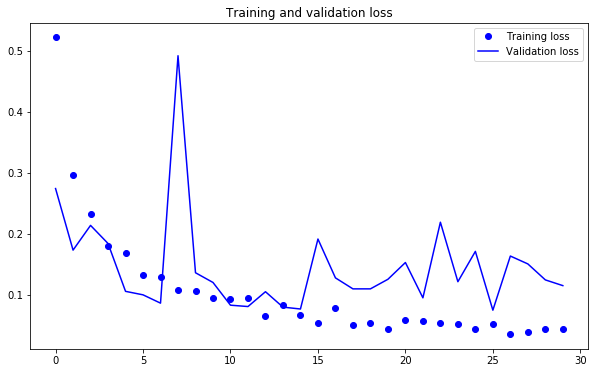

In [36]:
plt.figure(figsize = (10, 6))

plt.plot(epochs, 
         loss, 
         'bo', 
         label = 'Training loss')
plt.plot(epochs, 
         val_loss, 
         'b', 
         label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Fine-tuning

In [37]:
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [38]:
# Fine-tuning only block5_conv1, block5_conv2 and block5_conv3
network.trainable = True

set_trainable = False
for layer in network.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [39]:
# Compiling the network
end_to_end_model.compile(loss = 'binary_crossentropy',
                         optimizer = RMSprop(lr = 1e-5),
                         metrics = ['acc'])

## Training

In [40]:
history = end_to_end_model.fit_generator(train_generator,
                                         steps_per_epoch = 100,
                                         epochs = 100,
                                         validation_data = validation_generator,
                                         validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 26s - loss: 0.0158 - acc: 0.9950 - val_loss: 0.1306 - val_acc: 0.9710
Epoch 2/100
100/100 [==============================] - 24s - loss: 0.0155 - acc: 0.9965 - val_loss: 0.1559 - val_acc: 0.9700
Epoch 3/100
100/100 [==============================] - 24s - loss: 0.0146 - acc: 0.9950 - val_loss: 0.1165 - val_acc: 0.9740
Epoch 4/100
100/100 [==============================] - 23s - loss: 0.0177 - acc: 0.9935 - val_loss: 0.1547 - val_acc: 0.9690
Epoch 5/100
100/100 [==============================] - 24s - loss: 0.0211 - acc: 0.9945 - val_loss: 0.1068 - val_acc: 0.9730
Epoch 6/100
100/100 [==============================] - 23s - loss: 0.0138 - acc: 0.9930 - val_loss: 0.1402 - val_acc: 0.9720
Epoch 7/100
100/100 [==============================] - 27s - loss: 0.0111 - acc: 0.9965 - val_loss: 0.1485 - val_acc: 0.9720
Epoch 8/100
100/100 [==============================] - 23s - loss: 0.0244 - acc: 0.9920 - val_loss: 0.1409 - val_acc: 0.9680


100/100 [==============================] - 20s - loss: 0.0100 - acc: 0.9975 - val_loss: 0.1641 - val_acc: 0.9760
Epoch 67/100
100/100 [==============================] - 20s - loss: 0.0144 - acc: 0.9975 - val_loss: 0.1325 - val_acc: 0.9790
Epoch 68/100
100/100 [==============================] - 20s - loss: 0.0056 - acc: 0.9975 - val_loss: 0.1862 - val_acc: 0.9730
Epoch 69/100
100/100 [==============================] - 20s - loss: 0.0067 - acc: 0.9985 - val_loss: 0.2030 - val_acc: 0.9720
Epoch 70/100
100/100 [==============================] - 20s - loss: 0.0056 - acc: 0.9985 - val_loss: 0.1574 - val_acc: 0.9740
Epoch 71/100
100/100 [==============================] - 20s - loss: 0.0038 - acc: 0.9980 - val_loss: 0.1651 - val_acc: 0.9750
Epoch 72/100
100/100 [==============================] - 20s - loss: 0.0171 - acc: 0.9965 - val_loss: 0.1553 - val_acc: 0.9720
Epoch 73/100
100/100 [==============================] - 20s - loss: 0.0062 - acc: 0.9990 - val_loss: 0.1417 - val_acc: 0.9750
Epoch

In [41]:
model.save('.\saved_checkpoints\Chapter 5.3 - Using a pre-trained convnet\cats_and_dogs_small_4.h5')

In [42]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [43]:
epochs = range(len(acc))

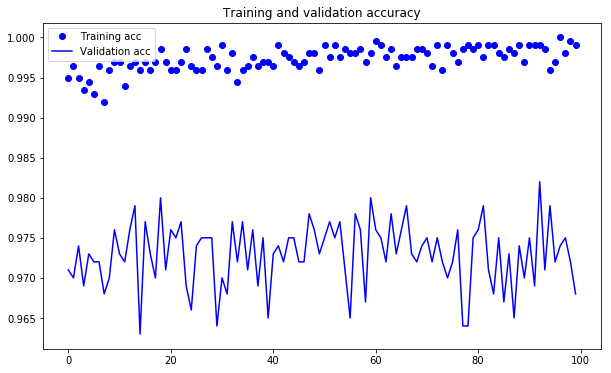

In [44]:
plt.figure(figsize = (10, 6))
plt.plot(epochs, 
         acc, 
         'bo', 
         label = 'Training acc')
plt.plot(epochs, 
         val_acc, 
         'b', 
         label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

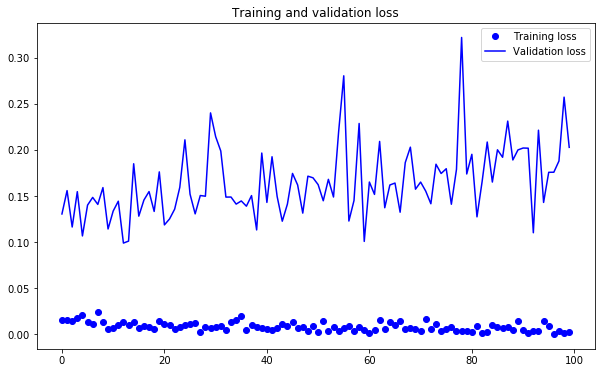

In [45]:
plt.figure(figsize = (10, 6))

plt.plot(epochs, 
         loss, 
         'bo', 
         label = 'Training loss')
plt.plot(epochs, 
         val_loss, 
         'b', 
         label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Smothed curves

In [46]:
def smooth_curve(points, factor = 0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

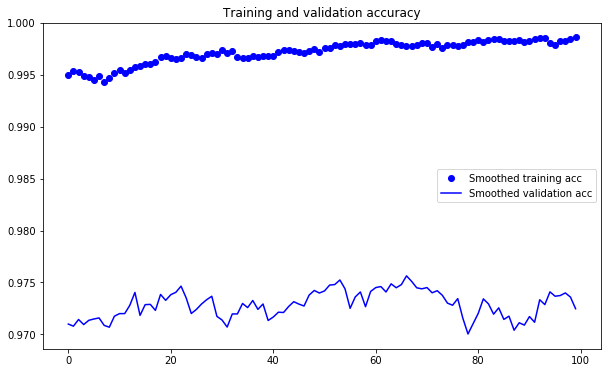

In [47]:
plt.figure(figsize = (10, 6))
plt.plot(epochs,
         smooth_curve(acc), 
         'bo', 
         label = 'Smoothed training acc')

plt.plot(epochs,
         smooth_curve(val_acc), 
         'b', 
         label = 'Smoothed validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.show()

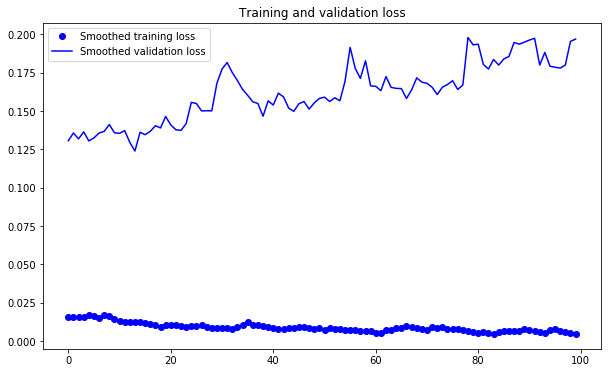

In [48]:
plt.figure(figsize = (10, 6))

plt.plot(epochs,
         smooth_curve(loss), 
         'bo', 
         label = 'Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 
         'b', 
         label = 'Smoothed validation loss')

plt.title('Training and validation loss')
plt.legend()

plt.show()

## Evaluation

In [49]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size = (150, 150),
                                                  batch_size = 20,
                                                  class_mode = 'binary')

test_loss, test_acc = end_to_end_model.evaluate_generator(test_generator, 
                                                          steps = 50)
print('Test acc:', test_acc)

Found 1000 images belonging to 2 classes.
Test acc: 0.973999993801
